# <b>Project 2: Features Engineering, Advanced Models and Model Interpretation</b>
> <div class="footer">
     &copy; 2020 Jackson Rico
</div>

<jacksonrico@gmail.com>

Import required Python packages.

In [1]:
%%time
%colors LightBG
from IPython.display import HTML

import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns
sns.diverging_palette(200, 10, as_cmap=True)
sns.set()

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn import set_config
set_config(display='diagram') 

from io import StringIO

import os
import sys
sys.version

Wall time: 53.2 s


'3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]'

In [2]:
# version libraries
import sklearn
modules = [np, pd, sns, mpl, sklearn] # numpy, pandas, seaborn, matplotlib, sklearn
row = '<tr> <td>%s</td> <td>%s</td> </tr>'
rows = '\n'.join([row % (module.__name__, module.__version__) for module in modules])
s = '<table> <tr><th>Library</th><th>Version</th> </tr> %s</table>' % rows
HTML(s)

Library,Version
numpy,1.19.1
pandas,1.1.0
seaborn,0.11.0
matplotlib,3.2.2
sklearn,0.23.1


In [3]:
%matplotlib inline

Option display notebook

In [4]:
# Display options
pd.reset_option("^display") 
pd.set_option('max_columns', 100) 
pd.set_option('max_rows', 20) 
pd.set_option('max_colwidth', 150)
pd.set_option("precision", 2)
pd.set_option('display.float_format', '{:,.2f}'.format) 

## <span style="color:blue">**SECTION A - Data Transformation**</span>

### 1. Reading, Exploratory, Selecting and Filtering of Data

#### Reading CSV

In [5]:
# Show current working directory
os.getcwd()
%cd

C:\Users\USUARIO


In [6]:
# Show list files in current working directory 
#os.listdir(os.getcwd())

In [7]:
# import dataset, select columns and chage dtype

mainpath = 'C:/CursosPython/02 Acámica/Bloque 1/Primer modelo de Machine Learning/datasets' # absolute path
filename = 'DS_Proyecto_01_Datos_Properati.csv'
fullpath = os.path.join(mainpath,filename)

# selecting columns
csv_col = ['l2','property_type', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']

# change dtype
dtypes = {'property_type':'string', 'l2':'category'}

# read data
%time data = pd.read_csv(fullpath, usecols=csv_col, dtype=dtypes)

# Shape
row, col = data.shape
print('Total row:\t {} \nTotal colums:\t {}'.format(row, col))

Wall time: 2.77 s
Total row:	 146660 
Total colums:	 8


In [8]:
# Copy dataset and see how much memory data use
%time df = data.copy()
#  memory usage of each column
new_mem = df.info(memory_usage='deep')
new_mem

Wall time: 17 ms
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146660 entries, 0 to 146659
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   l2               146660 non-null  category
 1   rooms            146660 non-null  float64 
 2   bedrooms         146660 non-null  float64 
 3   bathrooms        140703 non-null  float64 
 4   surface_total    126133 non-null  float64 
 5   surface_covered  125046 non-null  float64 
 6   price            146660 non-null  float64 
 7   property_type    146660 non-null  string  
dtypes: category(1), float64(6), string(1)
memory usage: 16.2 MB


#### Selecting and Filtering Data
Filtering Rows and Columns

In [9]:
# Filter rows and select column
best_region = ['Capital Federal'] # variable filtro -> l2
best_type = ['PH', 'Casa', 'Departamento'] # variable filtro -> property_type 
different_cols = ['property_type','rooms','bedrooms','bathrooms','surface_total','surface_covered','price']

df = df[df.l2.isin(best_region) & df.property_type.isin(best_type)]
df = df[different_cols].dropna(axis=0, how='all') # drop rows with all nans

cols = df.columns.values.tolist()

print(f'Columns: {cols}')

# Shape
row, col = df.shape
print('Total row:\t {} \nTotal colums:\t {}'.format(row, col))

Columns: ['property_type', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']
Total row:	 91485 
Total colums:	 7


In [10]:
# Instances with surface covered bigger to surface total
wrong_surface_rows = df.query('surface_total < surface_covered') # dataframe suf_cove > suf_total

print("Total rows surface_covered > surface_total: ", wrong_surface_rows.shape[0])
wrong_surface_rows.head(3)

Total rows surface_covered > surface_total:  760


,property_type,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
446,Casa,5.00,4.00,3.00,230.00,244.00,"490,000.00"
859,Departamento,3.00,2.00,1.00,43.00,44.00,"133,000.00"
924,Departamento,3.00,2.00,1.00,65.00,66.00,"187,000.00"


In [11]:
# Copy value from one column based on the value of another column
df.loc[wrong_surface_rows.index, 'surface_total'] = wrong_surface_rows.surface_covered

In [12]:
# Indexing with the query method
wrong_surface_rows = df.query('surface_total < surface_covered')
print("Total rows surface_covered > surface_total: ",wrong_surface_rows.shape[0])

Total rows surface_covered > surface_total:  0


In [13]:
# copy data 
%time df1 = df.copy()

Wall time: 6 ms


#### Exploratory of Data
Find missing values and values equal to cero

In [14]:
# Missing values and values equal to cero by columns
nan_col = df1.isna().sum()
cero_col = df1.isin([0]).sum()
nan_cero = pd.concat([nan_col, cero_col], axis=1, ignore_index=True).T.rename(index={0: 'NaN', 1:'Val_0'})
nan_cero.style.format("{:,.1f}")

,property_type,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
NaN,0.0,0.0,0.0,"2,171.0","8,917.0","9,235.0",0.0
Val_0,0.0,0.0,"2,217.0",0.0,0.0,0.0,0.0


In [15]:
# Missing values and iqual to cero by property type

# Dataframe with nan values
mask_nan = df1.isin([np.nan]).any(1)
df_nan = df1[mask_nan]

# total nan by property_type
total_nan = df_nan['property_type'].value_counts().to_frame('Property type NaNs')

# Dataframe with 0 values
mask_0 = df.isin([0]).any(1)
df_cero = df[mask_0]

# total 0 by property_type
total_cero = df_cero['property_type'].value_counts().to_frame('Property_type = 0')

pd.concat([total_nan, total_cero], axis=1).style.format("{:,.1f}")

,Property type NaNs,Property_type = 0
Departamento,"9,559.0","2,200.0"
Casa,534.0,12.0
PH,182.0,5.0


### 2. Imputation of missing values

In [16]:
# Create new dataframe for each type
types = df1['property_type'].unique()

d = {type: df1[df1['property_type'] == type] for type in types} # crea un diccionario keys= PH, Casa y Departamento
print(f'Dictionary keys: {list(d.keys())}')

Dictionary keys: ['Departamento', 'PH', 'Casa']


#### Imputation missing values and values cero

In [17]:
# replace values and new column price_m2
for i in d.keys():
    # replace values 0 to fill
    d[i] = d[i].replace(0, np.nan) # replace values 0 to fill
    # fill values nans, reset index
    d[i] = d[i].sort_values('price', ascending=False).fillna(method='ffill').reset_index(drop=True)
    # nueva columna calculada
    d[i]['price_m2'] = d[i]['price'] / d[i]['surface_total']

In [18]:
# Check Missing values and 0
df2 = result = pd.concat(d, ignore_index=True)
nan_col = df2.isna().sum()
cero_col = df2.isin([0]).sum()
nan_cero = pd.concat([nan_col, cero_col], axis=1, ignore_index=True).T.rename(index={0: 'NaN', 1:'Val_0'})
nan_cero.style.format("{:,.1f}")

,property_type,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,price_m2
NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Val_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3. Outlier

In [19]:
#  memory usage of each column
new_mem = df2.info(memory_usage='deep')
new_mem

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91485 entries, 0 to 91484
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   property_type    91485 non-null  string 
 1   rooms            91485 non-null  float64
 2   bedrooms         91485 non-null  float64
 3   bathrooms        91485 non-null  float64
 4   surface_total    91485 non-null  float64
 5   surface_covered  91485 non-null  float64
 6   price            91485 non-null  float64
 7   price_m2         91485 non-null  float64
dtypes: float64(7), string(1)
memory usage: 10.8 MB


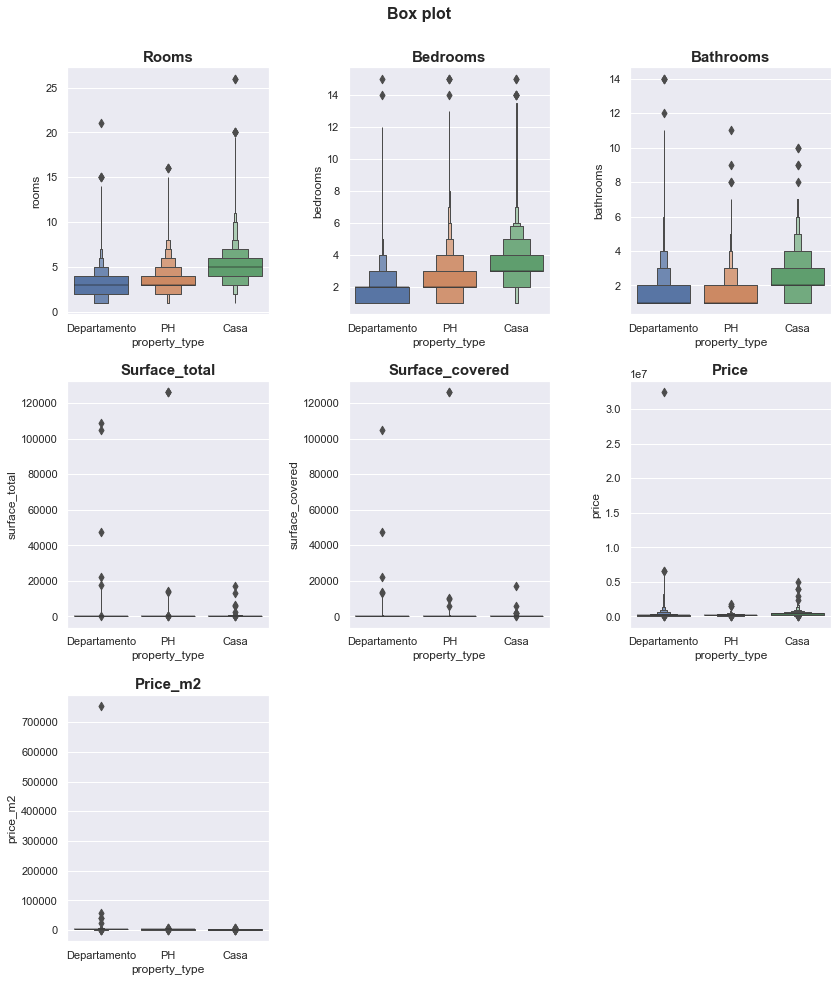

In [20]:
# box plot df2
X = df2._get_numeric_data().columns

plt.figure(figsize=(12, 14))
features = list(X)
for i, col in enumerate(features):
    plt.subplot(3, len(features)/2 , i+1)
    y = features[i]
    sns.boxenplot(x='property_type', y=y, data=df2)
    plt.title(col.capitalize(), fontsize=15, fontweight='bold')
    plt.tight_layout(pad=2)
    plt.subplots_adjust(top=0.92)
    #plt.ylabel(col)
    plt.suptitle("Box plot", fontsize=16, fontweight='bold')

#### Interquartile range

In [21]:
# Set the quantile
low = .25
high = .75
col_outlier = ['rooms', 'bathrooms','surface_total', 'surface_covered', 'price', 'price_m2'] # only select numerical data

bounds = {}
for type in types:
    filt_df = d[type].loc[:, col_outlier] # dataframe by columns
    quant_df = filt_df.quantile([low, high]) # dataframe by quantiles
    IQR = quant_df.iloc[1,:] - quant_df.iloc[0,:] # IQR values by columns / width box (row 0.75 - row 0.25)
    quant_df.iloc[0,:] = abs(quant_df.iloc[0,:] - 1.5*IQR) # whisker min
    quant_df.iloc[1,:] = abs(quant_df.iloc[1,:] + 1.5*IQR) # whisker max
    bounds[type] = quant_df
    
df_bounds = result = pd.concat(bounds, keys=bounds.keys(), names=['property_type', 'quartile'])
df_bounds

rooms  bathrooms  surface_total  surface_covered  \
property_type quartile                                                     
Departamento  0.25       1.00       0.50          29.50            22.50   
              0.75       7.00       3.50         174.50           149.50   
PH            0.25       1.50       0.50          54.50            40.88   
              0.75       5.50       3.50         277.50           220.12   
Casa          0.25       1.00       0.50          88.62            77.50   
              0.75       9.00       4.50         584.38           462.50   

                            price  price_m2  
property_type quartile                       
Departamento  0.25     106,000.00    654.52  
              0.75     494,000.00  4,845.65  
PH            0.25      67,500.00     18.56  
              0.75     472,500.00  3,778.59  
Casa          0.25     120,000.00    159.39  
              0.75     840,000.00  3,228.62

#### Removing outliers

In [22]:
# Let's remove the outliers from the dataset 
df_new = {} # dictionario

for i in d.keys():
    filt_df = d[i].loc[:, col_outlier]._get_numeric_data() # selec only numerical data
    filt_df = filt_df.apply(lambda x: x[(x > bounds[i].loc[low, x.name]) & 
                                        (x < bounds[i].loc[high, x.name])], axis=0)
    df_new[i] = pd.concat([d[i].loc[:,[col for col in d[i].columns if col not in col_outlier]], 
                     filt_df], axis=1).dropna(axis=0, how='any')

In [23]:
# short index and new order columns
new_col_order = ['property_type', 'rooms', 'bedrooms', 'bathrooms', 
                 'surface_total', 'surface_covered', 'price', 'price_m2']    

for i in df_new.keys():
    df_new[i] = df_new[i][new_col_order].reset_index(drop=True)


In [24]:
# new dataframe df3
df3 = result = pd.concat(df_new, ignore_index=True) # dataframe similar to data original

# Shape
row, col = df3.shape
print('Total row:\t {:,} \nTotal colums:\t {}'.format(row, col))

Total row:	 58,732 
Total colums:	 8


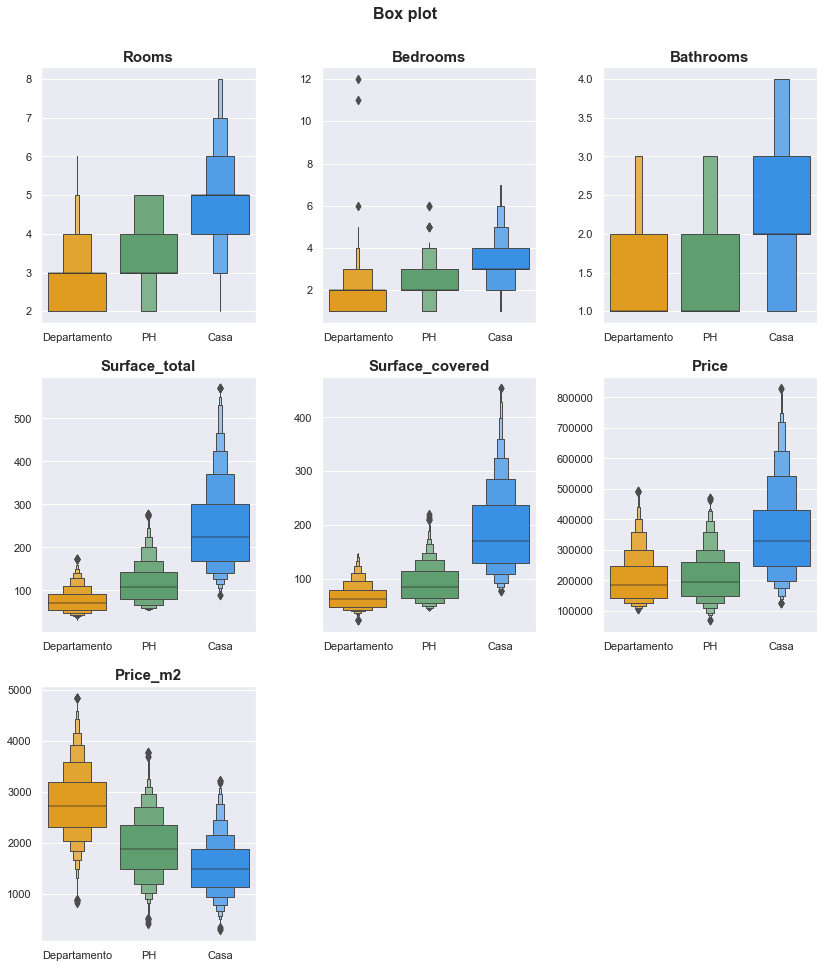

In [25]:
# box plot df3
X = df3._get_numeric_data().columns

plt.figure(figsize=(12, 14))
features = list(X)
for i, col in enumerate(features):
    plt.subplot(3, len(features)/2 , i+1)
    x = 'property_type'
    y = features[i]
    sns.boxenplot(x=x, y=y, data=df3, palette={'Departamento':'orange', 'PH':'g', 'Casa':'dodgerblue'})
    plt.title(col.capitalize(), fontsize=15, fontweight='bold')
    plt.tight_layout(pad=2)
    plt.xlabel('')
    plt.ylabel('')
    plt.subplots_adjust(top=0.92)
    plt.suptitle("Box plot", fontsize=16, fontweight='bold')

In [26]:
# Total rows deleted 
old_count = df.shape[0]
new_count = df3.shape[0]
print('Old Dataset df:\t\t{:,}'.format(old_count))
print('New Dataset df3:\t{:,}'.format(new_count))
print("Total rows deleted:\t{:,}".format(old_count-new_count))

Old Dataset df:		91,485
New Dataset df3:	58,732
Total rows deleted:	32,753


### 4. Writing CSV

In [27]:
## Export Dataframe CSV.
#fout = StringIO()
#df3.to_csv('Proyecto_02', index=False)

In [28]:
# Write dataframe in buffer
Proyect_02 = StringIO()
df3.to_csv(Proyect_02, index=False)

### 5. Read new dataset

In [29]:
# Read dataset csv
_ = Proyect_02.seek(0)

# convert dtypes
dtypes = {'property_type':'category',
          'bedrooms':'int8', 'rooms':'int8', 'bathrooms':'int8',
          'surface_total':'int16', 'surface_covered':'int16',
          'price':'int32', 'price_m2':'float64' 
         }

# read csv
data2 = pd.read_csv(Proyect_02, dtype=dtypes)

# Shape
row, col = data2.shape
print('Total row:\t {:,} \nTotal colums:\t {}\n'.format(row, col))

#  memory usage of each column
data2.info(memory_usage='deep')

Total row:	 58,732 
Total colums:	 8

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58732 entries, 0 to 58731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   property_type    58732 non-null  category
 1   rooms            58732 non-null  int8    
 2   bedrooms         58732 non-null  int8    
 3   bathrooms        58732 non-null  int8    
 4   surface_total    58732 non-null  int16   
 5   surface_covered  58732 non-null  int16   
 6   price            58732 non-null  int32   
 7   price_m2         58732 non-null  float64 
dtypes: category(1), float64(1), int16(2), int32(1), int8(3)
memory usage: 1.1 MB


In [30]:
# MG by columns
original_mem = data2.memory_usage(deep=True).to_frame().T / (1024**2) # MB
original_mem.style.format("{:.4f}")

,Index,property_type,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,price_m2
0,0.0001,0.0563,0.0560,0.0560,0.0560,0.1120,0.1120,0.2240,0.4481


In [31]:
# Describe
data2.describe().T

,count,mean,std,min,25%,50%,75%,max
rooms,"58,732.00",3.07,0.92,2.00,2.00,3.00,4.00,8.00
bedrooms,"58,732.00",2.03,0.86,1.00,1.00,2.00,3.00,12.00
bathrooms,"58,732.00",1.47,0.63,1.00,1.00,1.00,2.00,4.00
surface_total,"58,732.00",86.68,48.91,30.00,57.00,74.00,100.00,570.00
surface_covered,"58,732.00",74.84,37.48,23.00,50.00,65.00,88.00,454.00
price,"58,732.00","211,493.89","88,846.29","69,000.00","145,000.00","186,500.00","255,000.00","830,000.00"
price_m2,"58,732.00","2,630.89",743.35,293.48,"2,141.42","2,605.29","3,096.04","4,845.00"


### 6. Exploring the Data Distribution

#### Frequency table

In [32]:
# palette property type
palette = {'Departamento':'orange', 'PH':'g', 'Casa':'dodgerblue'}

In [33]:
# Frequency table of price by property type
binnedPrice = pd.cut(data2['price'] , 10, precision=1)

binnedPrice.name = 'binnedPrice'
df_bin = pd.concat([data2, binnedPrice], axis=1)
df_bin = df_bin.sort_values(by='price')

groups = []
for group, subset in df_bin.groupby(by='binnedPrice'):
    groups.append({
        'BinRange': group,
        'Count': len(subset),
        #'Property_type': ', '.join(subset.property_type.drop_duplicates()),
        'Departamento': ','.join(subset.property_type).count('Departamento'),
        'PH': ','.join(subset.property_type).count('PH'),
        'Casa': ','.join(subset.property_type).count('Casa'),
        'Mode': ','.join(subset.property_type.mode())
    })

df_freq = pd.DataFrame(groups)
df_freq

,BinRange,Count,Departamento,PH,Casa,Mode
0,"(68239.0, 145100.0]",15100,13476,1572,52,Departamento
1,"(145100.0, 221200.0]",22605,19627,2630,348,Departamento
2,"(221200.0, 297300.0]",12135,9884,1744,507,Departamento
3,"(297300.0, 373400.0]",5121,4073,584,464,Departamento
4,"(373400.0, 449500.0]",2582,1963,319,300,Departamento
5,"(449500.0, 525600.0]",891,664,25,202,Departamento
6,"(525600.0, 601700.0]",146,0,0,146,Casa
7,"(601700.0, 677800.0]",50,0,0,50,Casa
8,"(677800.0, 753900.0]",75,0,0,75,Casa
9,"(753900.0, 830000.0]",27,0,0,27,Casa


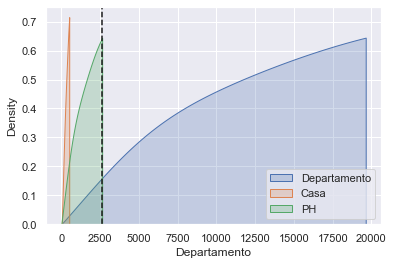

In [34]:
# Draw Bin Range cumulative

#kwargs = dict(histtype='stepfilled', alpha=0.3, bins=10, cumulative=True) # plt.hist
kwargs = dict(shade=True, cumulative=True) # kdeplot

kde_freq = df_freq.loc[:,['Departamento','Casa','PH']]

for col in kde_freq:
    #plt.hist(df_freq[col], **kwargs)
    sns.kdeplot(df_freq[col], **kwargs, palette='crest',cut=0)
plt.legend(kde_freq.columns, loc=4)
plt.axvline(kde_freq['PH'].max(), color="k", linestyle="--");

#### Visualization by Property type

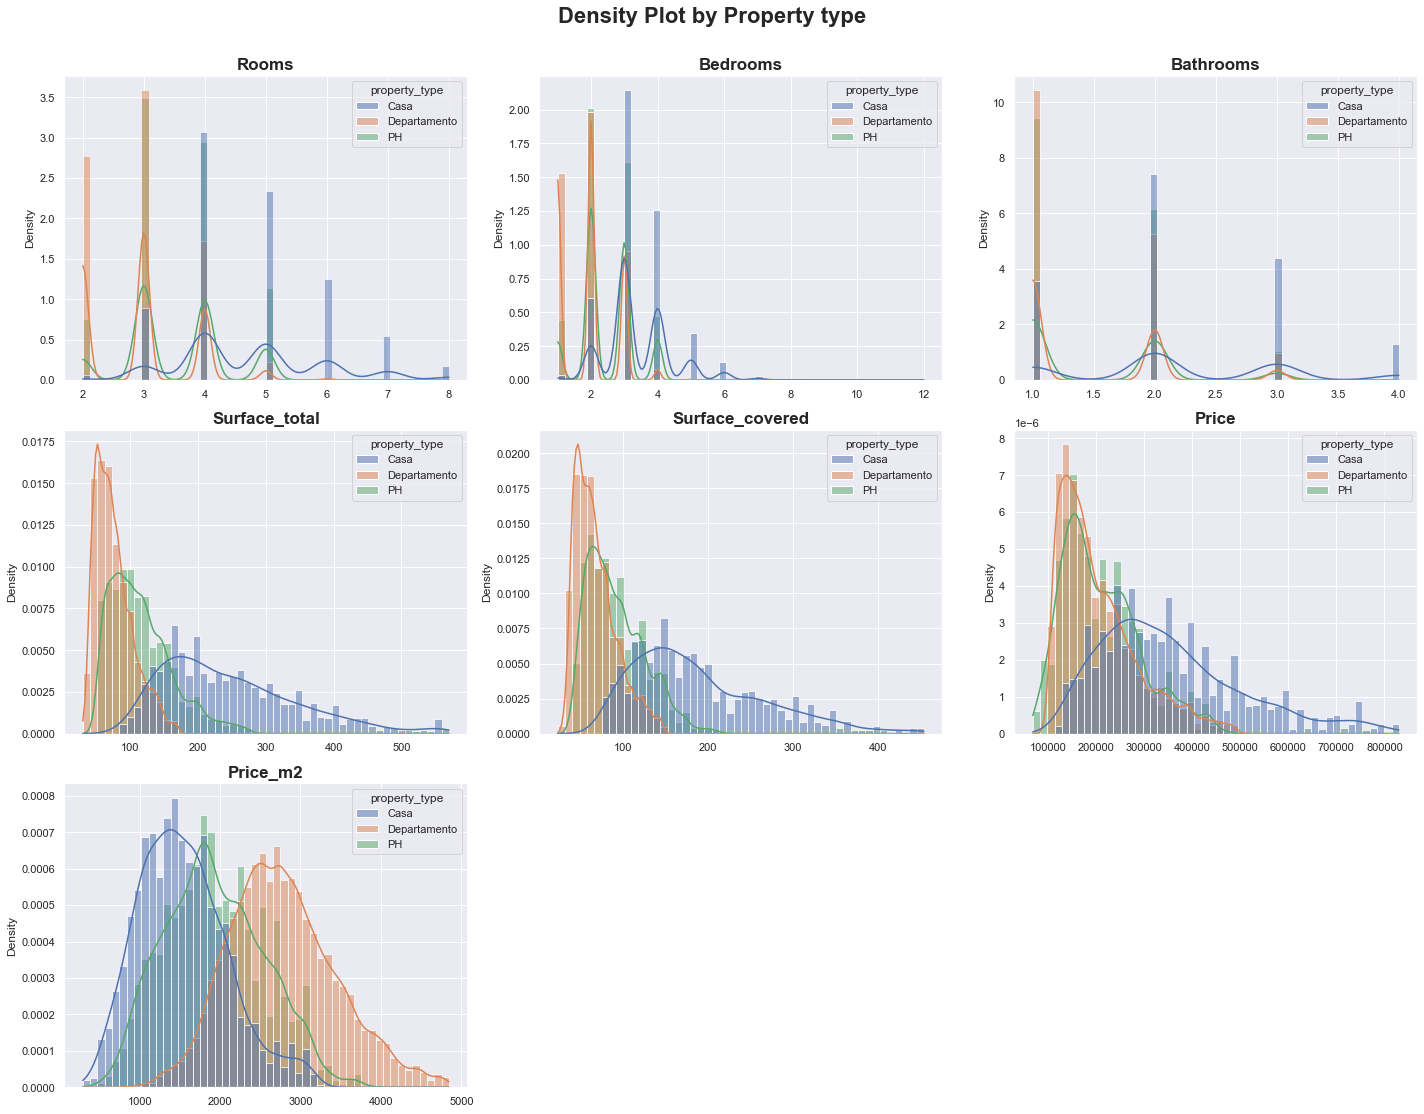

In [35]:
# Density plot
X = data2._get_numeric_data().columns
#kwargs = dict(hist_kws={'alpha':.7}, bins=40, kde_kws={"shade": True}, axlabel=False)

plt.figure(figsize=(20, 16))
features = list(X)

for i, col in enumerate(features):
    plt.subplot(3, len(features)/2 , i+1)
    #x = data2['property_type'].unique()
    x = features[i]
    sns.histplot(data2, x=x, hue='property_type', kde=True, element="bars", bins=50, stat='density', common_norm=False)
    plt.title(col.capitalize(), fontsize=17, fontweight='bold')
    plt.tight_layout(pad=1.5)
    plt.subplots_adjust(top=0.92)
    plt.suptitle("Density Plot by Property type", fontsize=22, fontweight='bold')
    plt.xlabel('')


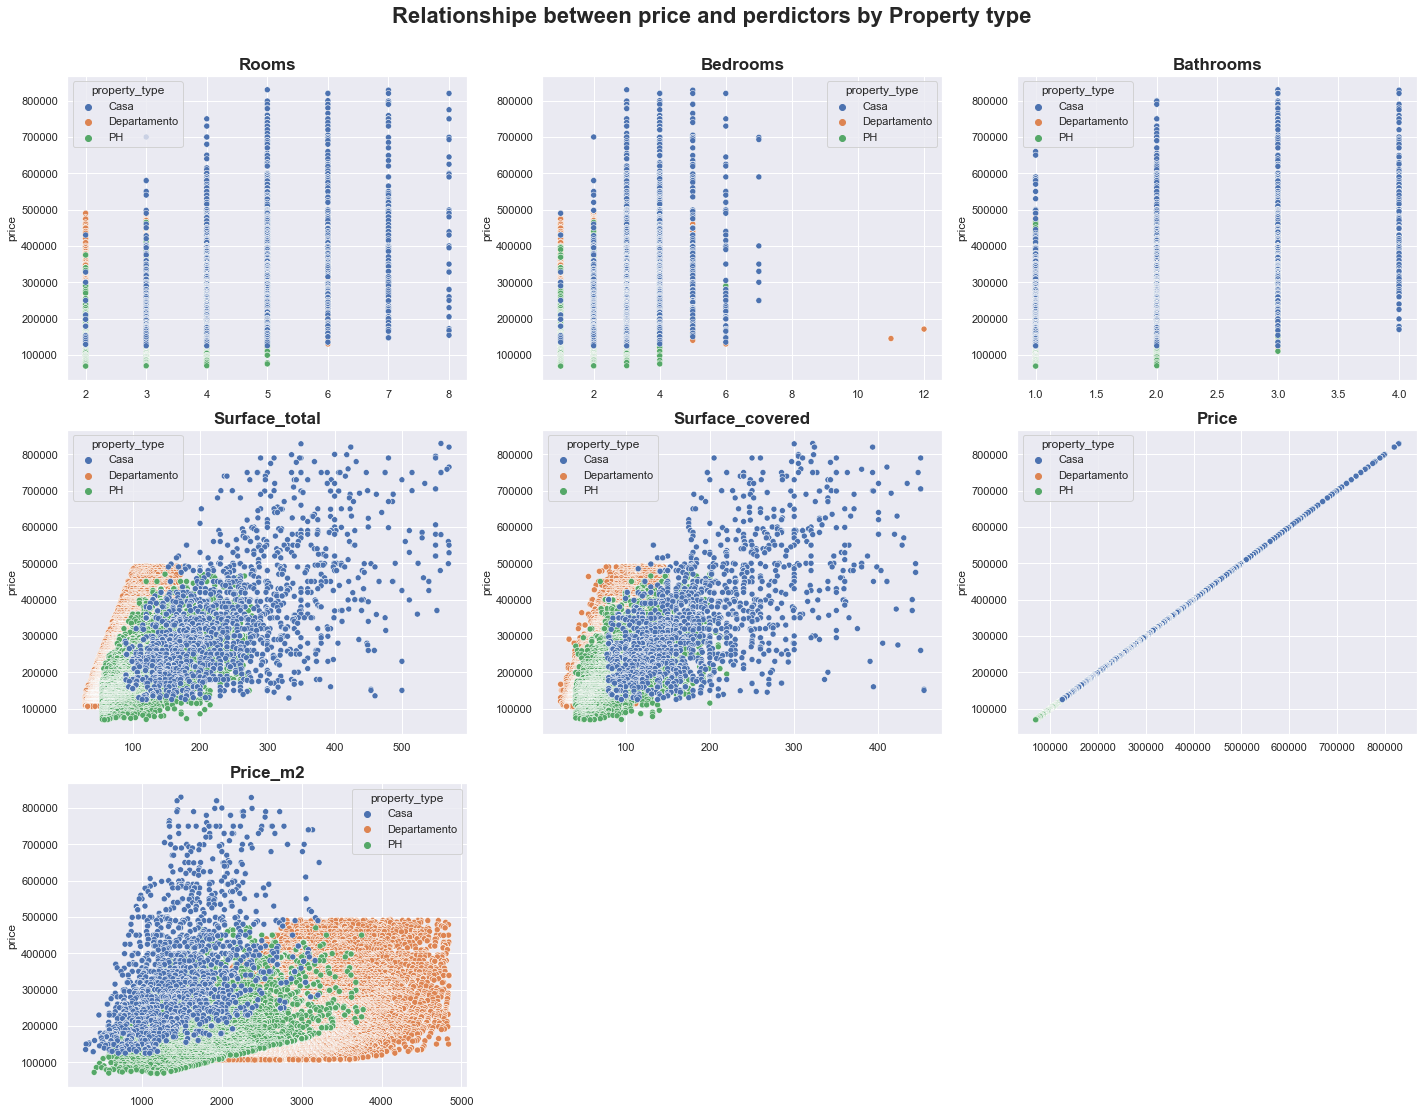

In [36]:
# scatterplot relationship beteween price and prediction variables
X = data2._get_numeric_data().columns
#kwargs = dict(hist_kws={'alpha':.7}, bins=40, kde_kws={"shade": True}, axlabel=False)

plt.figure(figsize=(20, 16))
features = list(X)

for i, col in enumerate(features):
    plt.subplot(3, len(features)/2 , i+1)
    #x = data2['property_type'].unique()
    x = features[i]
    sns.scatterplot(data=data2, x=x, y='price', hue='property_type')
    plt.title(col.capitalize(), fontsize=17, fontweight='bold')
    plt.tight_layout(pad=1.5)
    plt.subplots_adjust(top=0.92)
    plt.suptitle("Relationshipe between price and perdictors by Property type", fontsize=22, fontweight='bold')
    plt.xlabel('')


#### Data visualization target variable

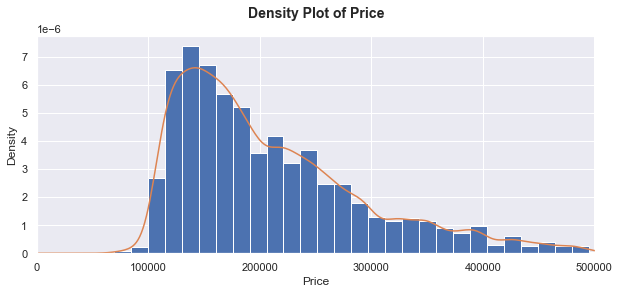

In [37]:
# Density plot target variable
ax = data2['price'].plot.hist(density=True, 
                                 xlim=[0, 500500],
                                 bins=50,
                                 figsize=(10, 4))
data2['price'].plot.density(ax=ax)
ax.set_xlabel('Price')

#plt.tight_layout()
# Decoration
plt.title('Density Plot of Price', fontsize=14, pad=18, fontweight='bold')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()

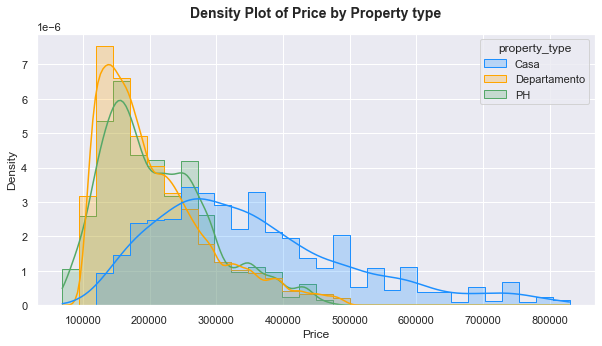

In [38]:
# Density Plot target variable by property type
f, ax = plt.subplots(figsize=(10, 5))


ax = sns.histplot(data2,
                  x="price", hue="property_type",
                  #multiple="stack",
                  stat='density',
                  element="step",
                  common_norm=False,
                  kde=True,
                  bins=30,
                  palette=palette,
                  #edgecolor=".3",
                  #linewidth=.5,
                  legend=True
                 )

# legend
#ax.legend(['PH','Departamento','Casa']).set_title(title='Property type', prop={'size':12, 'weight':'bold'})

#plt.ylim(0, 0.0008)
#plt.xlim(0, 5000)
#ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=5000, decimals=None, symbol='%', is_latex=False))

# Decoration
plt.title('Density Plot of Price by Property type', fontsize=14, pad=16, fontweight='bold')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()

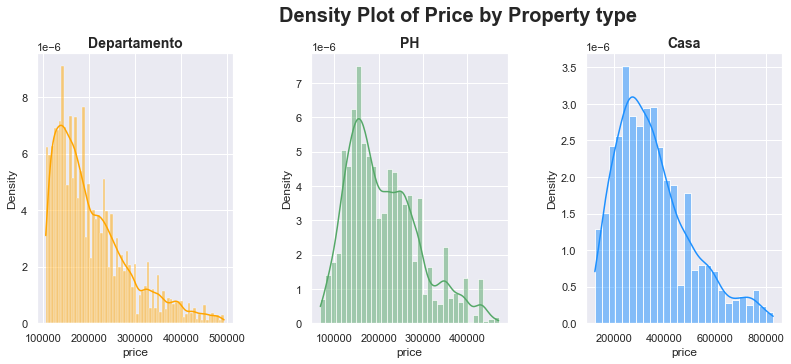

In [39]:
# Desnsity Plot
fig, ax = plt.subplots(1,3,figsize=(15, 5))

sns.histplot(data2.loc[data2['property_type']== 'Departamento',:], x='price',
            color="orange", kde=True, stat='density', ax=ax[0])
ax[0].set_title('Departamento', fontsize=14, fontweight='bold')
sns.histplot(data2.loc[data2['property_type']== 'PH',:], x='price',
            color="g", kde=True, stat='density', ax=ax[1])
ax[1].set_title('PH', fontsize=14, fontweight='bold')
sns.histplot(data2.loc[data2['property_type']== 'Casa',:], x='price',
            color="dodgerblue", stat='density', kde=True, ax=ax[2])
ax[2].set_title('Casa', fontsize=14, fontweight='bold')

#ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=5000, decimals=None, symbol='%', is_latex=False))

# Decoration
plt.suptitle('Density Plot of Price by Property type', fontsize=20, fontweight='bold')
plt.subplots_adjust(left=0.110, bottom=0.10, right=0.8, top=0.85, wspace=0.4, hspace=0.05)
plt.show()

#### Correlation

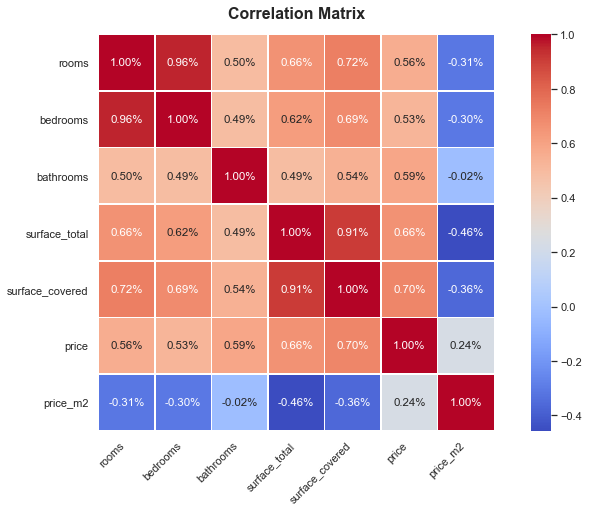

In [40]:
# correlation matrix 
plt.figure(figsize=(12, 12))


ax = sns.heatmap(data2.corr(), 
                 linewidths=.5, 
                 cbar = True, square = True, 
                 annot=True, fmt= '.2f', annot_kws={'size': 11.5}, cmap= 'coolwarm')
for t in ax.texts: t.set_text(t.get_text() + "%")
plt.xticks(rotation = 45, ha='right', x=1)
plt.title('Correlation Matrix', fontsize=16, fontweight='bold', pad= 16)
plt.tight_layout(pad=2)
plt.subplots_adjust(top=0.5)
plt.show()

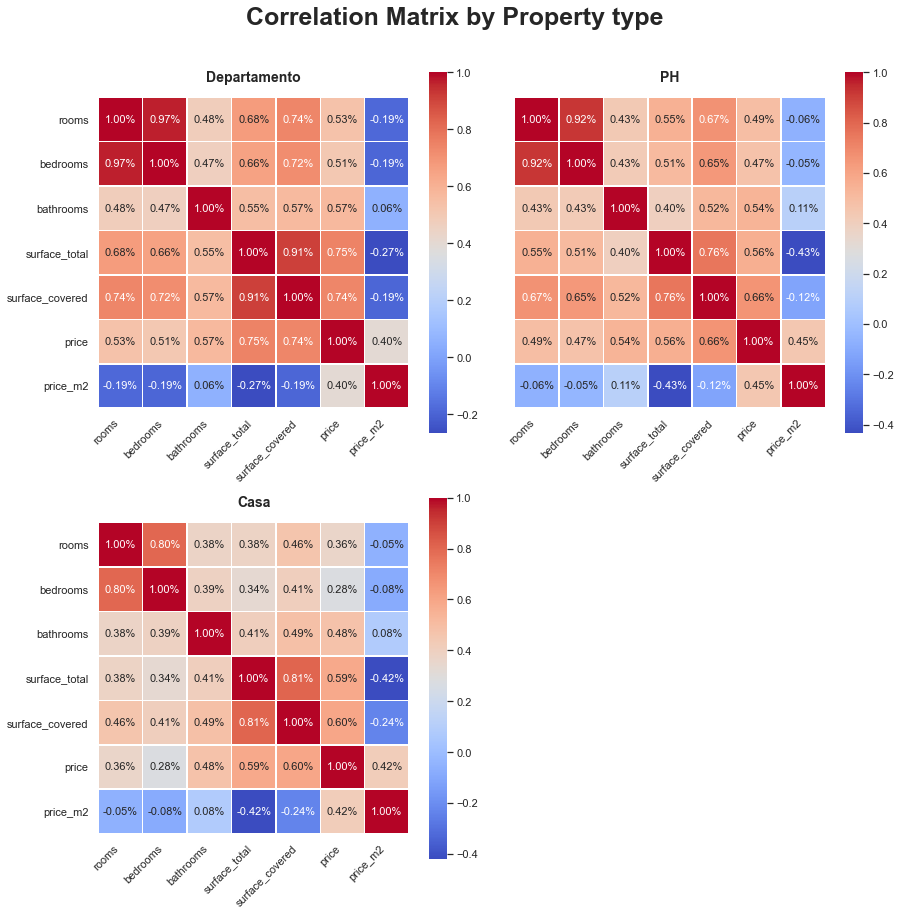

In [41]:
# Correaltion matrix by Property type
plt.figure(figsize=(13, 13))

ax1 = plt.subplot(221)
ax1 = sns.heatmap(data2.loc[data2['property_type']== 'Departamento', :].corr(), 
                  linewidths=.5, cbar = True, 
                  square = True, annot=True, fmt= '.2f', annot_kws={'size': 11},
                  cmap= 'coolwarm')
for t in ax1.texts: t.set_text(t.get_text() + "%")
plt.title('Departamento', fontsize=14, fontweight='bold', pad= 16)
plt.xticks(rotation = 45, ha='right', x=1)

ax2 = plt.subplot(222)
ax2 = sns.heatmap(data2.loc[data2['property_type']== 'PH', :].corr(), 
                  linewidths=.5, cbar = True, 
                  square = True, annot=True, fmt= '.2f', annot_kws={'size': 11},
                  cmap= 'coolwarm', yticklabels=False)
for t in ax2.texts: t.set_text(t.get_text() + "%")
plt.title('PH', fontsize=14, fontweight='bold', pad=16)
plt.xticks(rotation = 45, ha='right', x=1)

ax3 = plt.subplot(223)
ax3 = sns.heatmap(data2.loc[data2['property_type']== 'Casa', :].corr(), 
                  linewidths=.5, cbar = True, 
                  square = True, annot=True, fmt= '.2f', annot_kws={'size': 11},
                  cmap= 'coolwarm', yticklabels=True)
for t in ax3.texts: t.set_text(t.get_text() + "%")
plt.title('Casa', fontsize=14, fontweight='bold', pad=16)
plt.xticks(rotation = 45, ha='right', x=1)

plt.suptitle("Correlation Matrix by Property type", fontsize=25, fontweight='bold')
plt.tight_layout(pad=2)
plt.subplots_adjust(top=0.91)

plt.show()

### 7. Encoding, Scaling and ML

In [42]:
# Copy dataset 
house = data2.copy()
print(house.columns.tolist())

['property_type', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price', 'price_m2']


#### Dummy variables

In [43]:
# Data predictors, dummy, train_test, fit regression
predictors = ['property_type', 'bedrooms', 'bathrooms', 'surface_total']

outcome = 'price'

# Dummy Variables
X = pd.get_dummies(house[predictors], drop_first=True) # drop elimina Property_type Casa
y = house[outcome]

# Realizar un Train/Test split de los datos.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Modelos de regresion
reg = LinearRegression(normalize=True)

# Entrenamiento
reg.fit(X_train, y_train)

LinearRegression(normalize=True)

In [44]:
# Intercept and Coefficients
print(f'Intercept: {reg.intercept_:,.3f}')
print('Coefficients:')
for name, coef in zip(X, reg.coef_):
    print(f' {name}: {coef:,.3f}')

Intercept: -41,735.185
Coefficients:
 bedrooms: 9,366.898
 bathrooms: 39,116.460
 surface_total: 1,136.189
 property_type_Departamento: 86,829.935
 property_type_PH: 38,646.735


Model:Regresión lineal
Raíz del error cuadrático medio en Train: 57,811.94
Raíz del error cuadrático medio en Test: 59,546.64
Regression R2 Score: 57.0487%


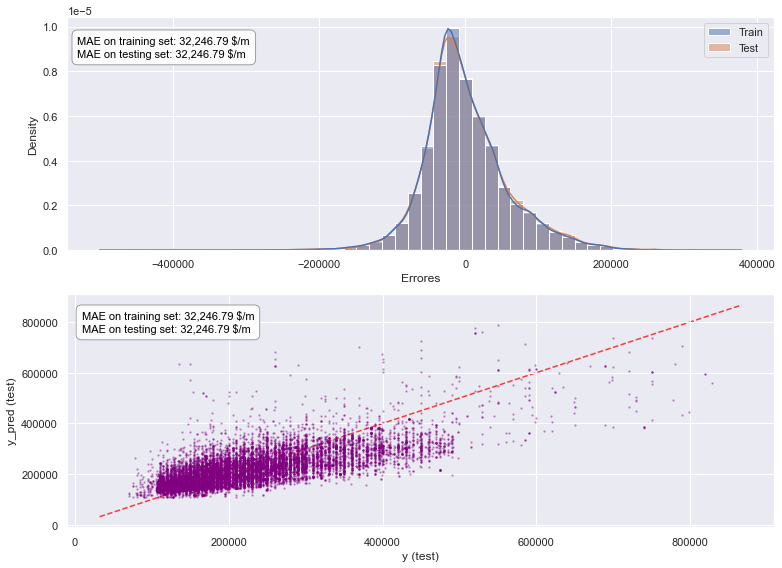

In [45]:
# Lineal Regression 

print(f'Model:Regresión lineal')

# predict
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test) 

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2 = r2_score(y_train, y_train_pred)
print('Raíz del error cuadrático medio en Train: {0:,.2f}'.format(rmse_train))
print('Raíz del error cuadrático medio en Test: {0:,.2f}'.format(rmse_test))
print('Regression R2 Score: {:,.4%}'.format(r2))
    
# Error absoluto medio    
mae = median_absolute_error(y_train, y_train_pred)
mae = median_absolute_error(y_test, y_test_pred)
string_score = f'MAE on training set: {mae:,.2f} $/m' + f'\nMAE on testing set: {mae:,.2f} $/m'

# variables
train_hist = {'Train': y_train - y_train_pred,
              'Test': y_test - y_test_pred}

# box annotate
bbox_props = dict(boxstyle="round, pad=0.5", fc='w', ec='0.5', lw=0.8, alpha=0.9) 

# plot histogram density
fig, ax = plt.subplots(2,1,figsize=(11, 8))

ax1 = plt.subplot(2,1,1)
sns.histplot(train_hist, 
             bins = 50, 
             kde=True, 
             stat='density', 
             common_norm=False, 
             legend=True, ax=ax1)
plt.xlabel('Errores')

# anotate
xmin, xmax, ymin, ymax = ax1.axis()
ax1.annotate(s=string_score,
             xy=(xmin, ymax),
             xytext=(10,-30), 
             textcoords='offset points',
             color='black', 
             size=11,
             ha = 'left', 
             va = 'center',
             bbox=bbox_props
)
#--------------------------------------------------------

# plot
ax2 = plt.subplot(2,1,2)
ax2 = sns.regplot(x =y_test, y=y_test_pred, ci=None, 
                  scatter_kws ={'color': 'purple', 'alpha': 0.3, "s": 8}, 
                  ax=ax2, 
                  fit_reg=False,
                  marker='.'
                 )

plt.annotate(s=string_score,
             xy=(0, 0), # xy=(-2000, 0.0006) ; xy=(xmin, ymax)
             xycoords='axes fraction',
             xytext=(0.02,0.88), # xytext=(10,-30)
             color='black', 
             size=11,
             ha = 'left', 
             va = 'center',
             bbox=bbox_props
)

lims = [np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
        np.max([ax2.get_xlim(), ax2.get_ylim()])]  # max of both axes

ax2.plot(lims, lims, 'k-', alpha=0.75, zorder=0, ls="--", c="red")

plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')

plt.tight_layout()
plt.show()

In [46]:
# Model Tree Regressor
tree_regressor = DecisionTreeRegressor(max_depth=25, random_state=42)
tree_regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=25, random_state=42)

Modelo: Tree Regressor
Raíz del error cuadrático medio en Train: 45,673.37
Raíz del error cuadrático medio en Test: 54,724.04
Regression R2 Score: 73.1918%


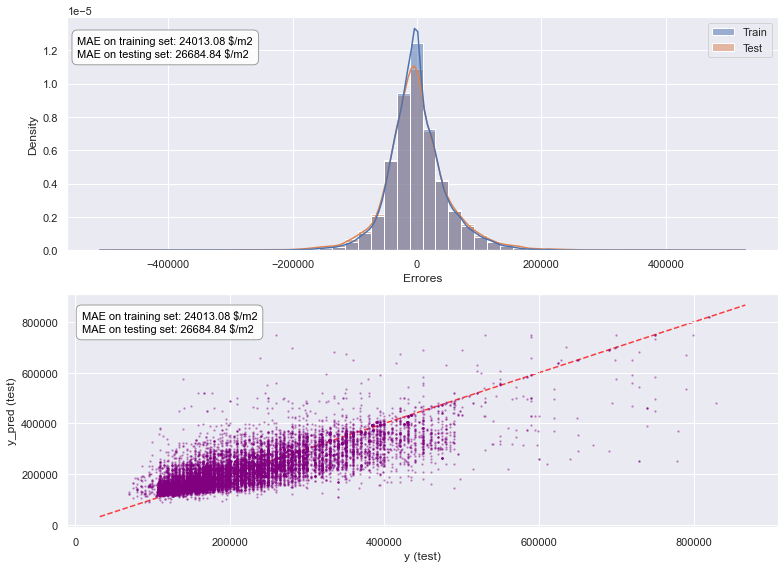

In [47]:
# Decision Tree Regressor

y_train_pred = tree_regressor.predict(X_train)
y_test_pred = tree_regressor.predict(X_test)   
print(f'Modelo: Tree Regressor')

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2 = r2_score(y_train, y_train_pred)
print('Raíz del error cuadrático medio en Train: {0:,.2f}'.format(rmse_train))
print('Raíz del error cuadrático medio en Test: {0:,.2f}'.format(rmse_test))
print('Regression R2 Score: {:,.4%}'.format(r2))
    
# Error absoluto medio    
mae = median_absolute_error(y_train, y_train_pred)
string_score = f'MAE on training set: {mae:.2f} $/m2'
mae = median_absolute_error(y_test, y_test_pred)
string_score += f'\nMAE on testing set: {mae:.2f} $/m2'

# variables
train_hist = {'Train': y_train - y_train_pred,
              'Test': y_test - y_test_pred}

# box annotate
bbox_props = dict(boxstyle="round, pad=0.5", fc='w', ec='0.5', lw=0.8, alpha=0.9) 

# plot histogram density
fig, ax = plt.subplots(2,1,figsize=(11, 8))

ax1 = plt.subplot(2,1,1)
sns.histplot(train_hist, 
             bins = 50, 
             #element='step',
             kde=True, stat='density',  
             common_norm=False, legend=True, ax=ax1)
plt.xlabel('Errores')


# anotate
xmin, xmax, ymin, ymax = ax1.axis()
ax1.annotate(s=string_score,
             xy=(xmin, ymax), # xy=(-2000, 0.0006) ; xy=(xmin, ymax)
             xytext=(10,-30), 
             textcoords='offset points',
             color='black', 
             size=11,
             ha = 'left', 
             va = 'center',
             bbox=bbox_props
)

#--------------------------------------------------------

# plot
ax2 = plt.subplot(2,1,2)
ax2 = sns.regplot(x =y_test, y=y_test_pred, ci=None, 
                  scatter_kws ={'color': 'purple', 'alpha': 0.3, "s": 8}, 
                  ax=ax2, 
                  fit_reg=False,
                  marker='.'
                 )

plt.annotate(s=string_score,
             xy=(0, 0), # xy=(-2000, 0.0006) ; xy=(xmin, ymax)
             xycoords='axes fraction',
             xytext=(0.02,0.88), # xytext=(10,-30)
             color='black', 
             size=11,
             ha = 'left', 
             va = 'center',
             bbox=bbox_props
)

lims = [np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
        np.max([ax2.get_xlim(), ax2.get_ylim()])]  # max of both axes


ax2.plot(lims, lims, 'k-', alpha=0.75, zorder=0, ls="--", c="red")

plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')

plt.tight_layout()
plt.show()

#### Scaling data and Dummy variables

In [48]:
# data scaling and dummy
house_n = house._get_numeric_data()

scaler = StandardScaler() # Creación del objeto
df_scaler = pd.DataFrame(scaler.fit_transform(house_n), columns=house_n.columns)

# The get_dummies function.
house_s = pd.concat([df_scaler, pd.get_dummies(house['property_type'],drop_first=True)], axis=1) # encode type

house_s.head(3)#.style.format('{:,.4f}')

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,price_m2,Departamento,PH
0,-0.08,-0.04,2.42,0.68,1.20,3.17,1.99,1,0
1,1.01,1.13,0.84,1.60,1.55,3.16,0.47,1,0
2,1.01,1.13,2.42,1.60,1.55,3.15,0.47,1,0


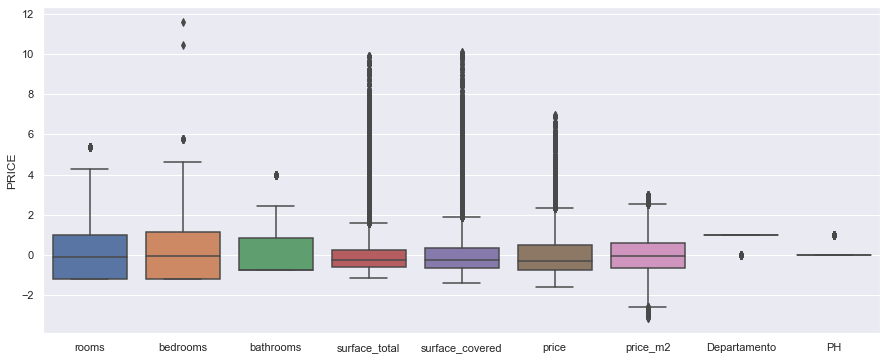

In [49]:
# plot feature distribution after scaling
house_s_melted = pd.melt(house_s)

plt.figure(figsize = (15,6))
sns.boxplot(x="variable", y="value", data=house_s_melted)
plt.ylabel('PRICE')
plt.xlabel('')
#fig.set_xticklabels(fig.get_xticklabels(),rotation=30)
plt.show()

In [50]:
# Linear regression
outcome = 'price'

# Variables
X = house_s.drop(columns=['price_m2','price', 'rooms', 'surface_covered'])
y = house_s[outcome]

# Realizar un Train/Test split de los datos.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Modelos de regresion
reg = LinearRegression(normalize=True)

# Entrenamiento
reg.fit(X_train, y_train)

LinearRegression(normalize=True)

In [51]:
# Intercept and Coefficients
print(f'Intercept: {reg.intercept_:,.3f}')
print('Coefficients:')
for name, coef in zip(X, reg.coef_):
    print(f' {name}: {coef:,.3f}')

Intercept: -0.881
Coefficients:
 bedrooms: 0.091
 bathrooms: 0.279
 surface_total: 0.625
 Departamento: 0.977
 PH: 0.435


Modelo: Regresión lineal
Raíz del error cuadrático medio en Train: 0.65
Raíz del error cuadrático medio en Test: 0.67
Regression R2 Score: 57.0487%


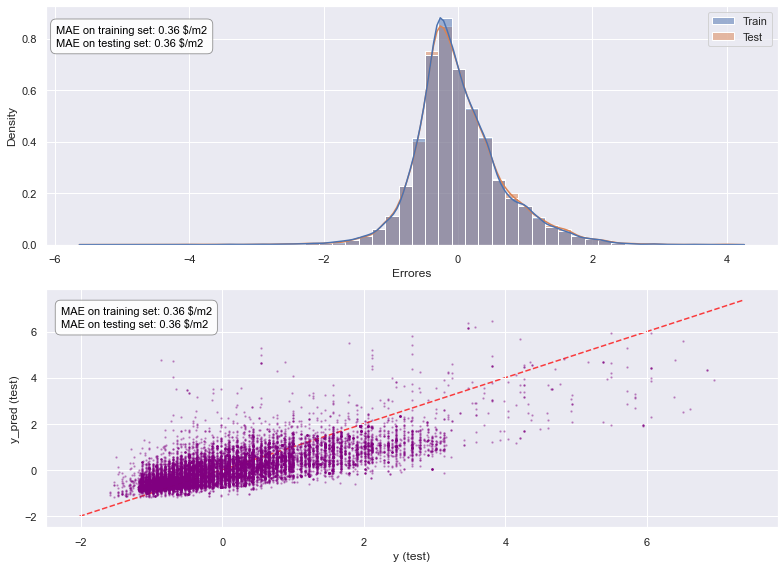

In [52]:
# Regresión lineal

y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)   
print(f'Modelo: Regresión lineal')

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2 = r2_score(y_train, y_train_pred)
print('Raíz del error cuadrático medio en Train: {0:,.2f}'.format(rmse_train))
print('Raíz del error cuadrático medio en Test: {0:,.2f}'.format(rmse_test))
print('Regression R2 Score: {:,.4%}'.format(r2))
    
# Error absoluto medio    
mae = median_absolute_error(y_train, y_train_pred)
string_score = f'MAE on training set: {mae:.2f} $/m2'
mae = median_absolute_error(y_test, y_test_pred)
string_score += f'\nMAE on testing set: {mae:.2f} $/m2'

# variables
train_hist = {'Train': y_train - y_train_pred,
              'Test': y_test - y_test_pred}

# box annotate
bbox_props = dict(boxstyle="round, pad=0.5", fc='w', ec='0.5', lw=0.8, alpha=0.9) 

# plot histogram density
fig, ax = plt.subplots(2,1,figsize=(11, 8))

ax1 = plt.subplot(2,1,1)
sns.histplot(train_hist, 
             bins = 50, 
             kde=True, 
             stat='density', common_norm=False, 
             legend=True, ax=ax1)
plt.xlabel('Errores')

# anotate
xmin, xmax, ymin, ymax = ax1.axis()
ax1.annotate(s=string_score,
             xy=(xmin, ymax), # xy=(-2000, 0.0006) ; xy=(xmin, ymax)
             xytext=(10,-30), 
             textcoords='offset points',
             color='black', 
             size=11,
             ha = 'left', 
             va = 'center',
             bbox=bbox_props
)
#--------------------------------------------------------

# plot
ax2 = plt.subplot(2,1,2)
ax2 = sns.regplot(x =y_test, y=y_test_pred, ci=None, 
                  scatter_kws ={'color': 'purple', 'alpha': 0.3, "s": 8}, 
                  ax=ax2, 
                  fit_reg=False,
                  marker='.'
                 )

plt.annotate(s=string_score,
             xy=(0, 0), # xy=(-2000, 0.0006) ; xy=(xmin, ymax)
             xycoords='axes fraction',
             xytext=(0.02,0.88), # xytext=(10,-30)
             color='black', 
             size=11,
             ha = 'left', 
             va = 'center',
             bbox=bbox_props
)

lims = [np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
        np.max([ax2.get_xlim(), ax2.get_ylim()])]  # max of both axes


ax2.plot(lims, lims, 'k-', alpha=0.75, zorder=0, ls="--", c="red")

plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')

plt.tight_layout()
plt.show()

In [53]:
# Model Tree regreessor
tree_regressor = DecisionTreeRegressor(max_depth=22, random_state=42)
tree_regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=22, random_state=42)

Modelo: Decision Tree Regressor
Raíz del error cuadrático medio en Train: 0.51
Raíz del error cuadrático medio en Test: 0.62
Regression R2 Score: 73.1623%


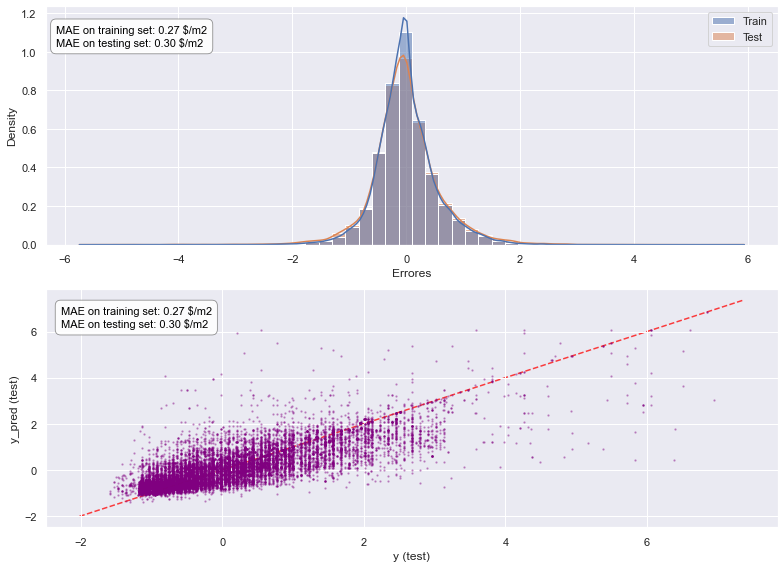

In [54]:
# Decision Tree Regressor

y_train_pred = tree_regressor.predict(X_train)
y_test_pred = tree_regressor.predict(X_test)   
print(f'Modelo: Decision Tree Regressor')

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2 = r2_score(y_train, y_train_pred)
print('Raíz del error cuadrático medio en Train: {0:,.2f}'.format(rmse_train))
print('Raíz del error cuadrático medio en Test: {0:,.2f}'.format(rmse_test))
print('Regression R2 Score: {:,.4%}'.format(r2))

# Error absoluto medio    
mae = median_absolute_error(y_train, y_train_pred)
string_score = f'MAE on training set: {mae:.2f} $/m2'
mae = median_absolute_error(y_test, y_test_pred)
string_score += f'\nMAE on testing set: {mae:.2f} $/m2'

# variables
train_hist = {'Train': y_train - y_train_pred,
              'Test': y_test - y_test_pred}

# box annotate
bbox_props = dict(boxstyle="round, pad=0.5", fc='w', ec='0.5', lw=0.8, alpha=0.9) 

# plot histogram density
fig, ax = plt.subplots(2,1,figsize=(11, 8))

ax1 = plt.subplot(2,1,1)
sns.histplot(train_hist, 
             bins = 50, 
             #element='step',
             kde=True, stat='density',  
             common_norm=False, legend=True, ax=ax1)
plt.xlabel('Errores')
#plt.xlim((-1000, 1000))

# anotate
xmin, xmax, ymin, ymax = ax1.axis()
ax1.annotate(s=string_score,
             xy=(xmin, ymax), # xy=(-2000, 0.0006) ; xy=(xmin, ymax)
             xytext=(10,-30), 
             textcoords='offset points',
             color='black', 
             size=11,
             ha = 'left', 
             va = 'center',
             bbox=bbox_props
)

#--------------------------------------------------------

# plot
ax2 = plt.subplot(2,1,2)
ax2 = sns.regplot(x=y_test, y=y_test_pred, ci=None, 
                  scatter_kws ={'color': 'purple', 'alpha': 0.3, "s": 8}, 
                  ax=ax2, 
                  fit_reg=False,
                  marker='.'
                 )

plt.annotate(s=string_score,
             xy=(0, 0), # xy=(-2000, 0.0006) ; xy=(xmin, ymax)
             xycoords='axes fraction',
             xytext=(0.02,0.88), # xytext=(10,-30)
             color='black', 
             size=11,
             ha = 'left', 
             va = 'center',
             bbox=bbox_props
)

lims = [np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
        np.max([ax2.get_xlim(), ax2.get_ylim()])]  # max of both axes


ax2.plot(lims, lims, 'k-', alpha=0.75, zorder=0, ls="--", c="red")

plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')

plt.tight_layout()
plt.show()

## <span style="color:blue"><b>SECTION B - Advanced Models</b></span>

### 1. Linear Regression with Polynomial Features

In [55]:
# Linear Regression with Polynomial Feautres

outcome = 'price'

# Variables scaler
X = house_s.drop(columns=['price_m2','price', 'rooms', 'surface_covered'])
y = house_s[outcome]

# Constructing train and test dataset.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

poly = PolynomialFeatures(degree = 4, include_bias=False)
X_train_new = poly.fit_transform(X_train)
X_test_new = poly.fit_transform(X_test)

reg_2 = LinearRegression(normalize=True, n_jobs=-1)
reg_2.fit(X_train_new, y_train)

rkf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
cv_model = cross_validate(reg_2, X_train_new, y_train, 
                          scoring=['r2', 'neg_mean_squared_error'], 
                          cv=rkf, return_estimator=False, return_train_score=True,
                          n_jobs=-1, error_score='raise', verbose=False)

# Intercept and Coefficients
print(f'Intercept: {reg_2.intercept_:,.3f}')
print('Coefficients:')
for name, coef in zip(X, reg_2.coef_):
    print(f' {name}: {coef:,.3f}')

Intercept: 1,953,008,136.543
Coefficients:
 bedrooms: -0.113
 bathrooms: -987,587,052.507
 surface_total: -0.002
 Departamento: 304,956,837,777.008
 PH: -893,673,946,883.122


In [56]:
# score
rmse_train = np.sqrt(-cv_model['train_neg_mean_squared_error']).mean()
rmse_test = np.sqrt(-cv_model['test_neg_mean_squared_error']).mean()
r2 = np.mean(cv_model['train_r2'])
print('RMSE Train: {0:,.2f}'.format(rmse_train))
print('RMSE Test: {0:,.2f}'.format(rmse_test))
print('Regression R2 Score: {:,.4%}'.format(r2))

RMSE Train: 0.61
RMSE Test: 0.61
Regression R2 Score: 62.3476%


### 2. Tree Regression with Polynomial Features 

In [57]:
# Linear Regression with Polynomial Features


tree_2 = DecisionTreeRegressor(max_depth=25, random_state=42)


cv_model = cross_validate(tree_2, X_train_new, y_train, 
                          scoring=['r2', 'neg_mean_squared_error'], 
                          cv=rkf, return_estimator=False, return_train_score=True,
                          n_jobs=-1, error_score='raise', verbose=False)

tree_2.fit(X_train_new, y_train)

DecisionTreeRegressor(max_depth=25, random_state=42)

In [58]:
# Intercept and Coefficients
print(f'Intercept: {reg_2.intercept_:,.3f}')
print('Coefficients:')
for name, coef in zip(X, reg_2.coef_):
    print(f' {name}: {coef:,.3f}')

Intercept: 1,953,008,136.543
Coefficients:
 bedrooms: -0.113
 bathrooms: -987,587,052.507
 surface_total: -0.002
 Departamento: 304,956,837,777.008
 PH: -893,673,946,883.122


In [59]:
# score
rmse_train = np.sqrt(-cv_model['train_neg_mean_squared_error']).mean()
rmse_test = np.sqrt(-cv_model['test_neg_mean_squared_error']).mean()
r2 = np.mean(cv_model['train_r2'])
print('RMSE Train: {0:,.2f}'.format(rmse_train))
print('RMSE Test: {0:,.2f}'.format(rmse_test))
print('Regression R2 Score: {:,.4%}'.format(r2))

RMSE Train: 0.51
RMSE Test: 0.62
Regression R2 Score: 73.3280%


### 3.  Tree Regressor with Polynomial Features and GridSearchCV

In [60]:
# Grilla para Grid Search
param_grid = {'criterion':['mse'],
              'max_depth':[17,18,19], # profundidad max del arbol.
              'min_samples_split':[3,4,5], # Min de muestras para la division del nodo
              'min_samples_leaf':[38,40,45], # min de muestras por hoja
              'max_leaf_nodes':[273,275,277], # maximo de hojas por nodo
              'max_features': ['auto']
             } 

scoring = {'R2': 'r2', 
           'MSE': 'neg_mean_squared_error',
          }


# Grid Search
model = GridSearchCV(tree_regressor, param_grid=param_grid, scoring=scoring, 
                           cv=10, refit='R2', # specific metric or best_index_ o get_best_index
                           return_train_score=True, n_jobs=-1)

# Train model
%time model.fit(X_train_new, y_train)

Wall time: 11min 31s


GridSearchCV(cv=10,
             estimator=DecisionTreeRegressor(max_depth=22, random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['mse'], 'max_depth': [17, 18, 19],
                         'max_features': ['auto'],
                         'max_leaf_nodes': [273, 275, 277],
                         'min_samples_leaf': [38, 40, 45],
                         'min_samples_split': [3, 4, 5]},
             refit='R2', return_train_score=True,
             scoring={'MSE': 'neg_mean_squared_error', 'R2': 'r2'})

In [61]:
# Score and best parameters
#print("Best Score {}: {:0.4%}\n".format(model.refit, model.best_score_)) # metric specified in refit='R2'
print('Best parameter:{}'.format(model.best_params_))

Best parameter:{'criterion': 'mse', 'max_depth': 18, 'max_features': 'auto', 'max_leaf_nodes': 275, 'min_samples_leaf': 40, 'min_samples_split': 3}


Modelo: Decision Tree Regressor
RMSE Train: 0.58
RMSE Test: 0.61
Regression R2 Score: 66.2775%


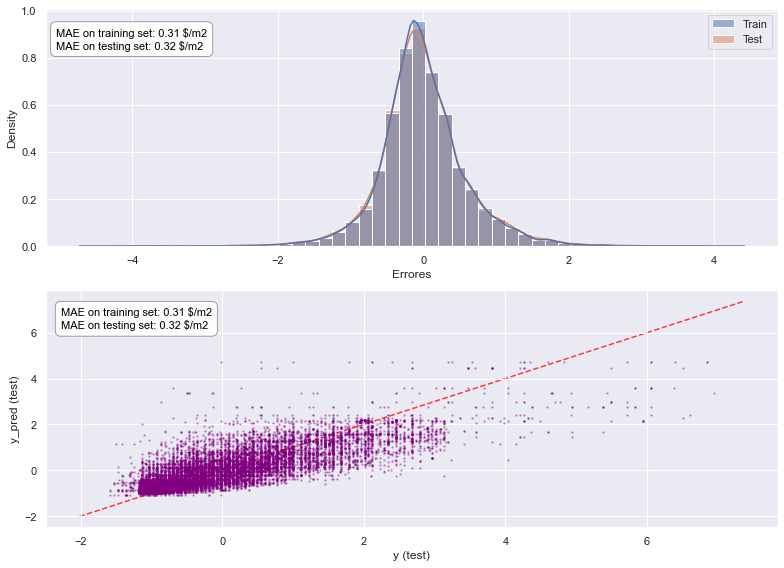

In [62]:
# Decision Tree Regressor

y_train_pred = model.predict(X_train_new)
y_test_pred = model.predict(X_test_new)   
print(f'Modelo: Decision Tree Regressor')

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2 = r2_score(y_train, y_train_pred)
print('RMSE Train: {0:,.2f}'.format(rmse_train))
print('RMSE Test: {0:,.2f}'.format(rmse_test))
print('Regression R2 Score: {:,.4%}'.format(r2))

# Error absoluto medio    
mae = median_absolute_error(y_train, y_train_pred)
string_score = f'MAE on training set: {mae:.2f} $/m2'
mae = median_absolute_error(y_test, y_test_pred)
string_score += f'\nMAE on testing set: {mae:.2f} $/m2'

# variables
train_hist = {'Train': y_train - y_train_pred,
              'Test': y_test - y_test_pred}

# box annotate
bbox_props = dict(boxstyle="round, pad=0.5", fc='w', ec='0.5', lw=0.8, alpha=0.9) 

# plot histogram density
fig, ax = plt.subplots(2,1,figsize=(11, 8))

ax1 = plt.subplot(2,1,1)
sns.histplot(train_hist, 
             bins = 50, 
             #element='step',
             kde=True, stat='density',  
             common_norm=False, legend=True, ax=ax1)
plt.xlabel('Errores')
#plt.xlim((-1000, 1000))

# anotate
xmin, xmax, ymin, ymax = ax1.axis()
ax1.annotate(s=string_score,
             xy=(xmin, ymax), # xy=(-2000, 0.0006) ; xy=(xmin, ymax)
             xytext=(10,-30), 
             textcoords='offset points',
             color='black', 
             size=11,
             ha = 'left', 
             va = 'center',
             bbox=bbox_props
)

#--------------------------------------------------------

# plot
ax2 = plt.subplot(2,1,2)
ax2 = sns.regplot(x=y_test, y=y_test_pred, ci=None, 
                  scatter_kws ={'color': 'purple', 'alpha': 0.3, "s": 8}, 
                  ax=ax2, 
                  fit_reg=False,
                  marker='.'
                 )

plt.annotate(s=string_score,
             xy=(0, 0), # xy=(-2000, 0.0006) ; xy=(xmin, ymax)
             xycoords='axes fraction',
             xytext=(0.02,0.88), # xytext=(10,-30)
             color='black', 
             size=11,
             ha = 'left', 
             va = 'center',
             bbox=bbox_props
)

lims = [np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
        np.max([ax2.get_xlim(), ax2.get_ylim()])]  # max of both axes


ax2.plot(lims, lims, 'k-', alpha=0.75, zorder=0, ls="--", c="red")

plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')

plt.tight_layout()
plt.show()

In [63]:
# Data frame result GridSearchCV
resultGridS = pd.DataFrame(model.cv_results_)
resultGridS_parm = pd.concat([pd.DataFrame(model.cv_results_["params"]), 
                              pd.DataFrame(model.cv_results_['mean_train_R2'], 
                                           columns=["Accuracy R2"]),
                              pd.DataFrame(model.cv_results_['mean_train_MSE'],
                                           columns=["Accuracy MSE"]),
                             ], axis=1)


index_model = model.best_index_
print(f'Best index parameter: {index_model}')
resultGridS_parm.loc[index_model:index_model+5,:]

Best index parameter: 39


,criterion,max_depth,max_features,max_leaf_nodes,min_samples_leaf,min_samples_split,Accuracy R2,Accuracy MSE
39,mse,18,auto,275,40,3,0.66,-0.33
40,mse,18,auto,275,40,4,0.66,-0.33
41,mse,18,auto,275,40,5,0.66,-0.33
42,mse,18,auto,275,45,3,0.66,-0.34
43,mse,18,auto,275,45,4,0.66,-0.34
44,mse,18,auto,275,45,5,0.66,-0.34


##  <span style="color:blue"><b>SECTION C - Interpretation of models</b></span>


**``- Predictors (X) = property_type (Departamento, PH), 'bedrooms', 'bathrooms', 'surface_total'``**

**``- Target (y) = price``**

----
### Project Block 1

**``Total rows = 81,019``**

#### Machine Learning Result 

**``Model: Linear Regression``**
+ Root mean squared error Train: 199,683.42
+ Root mean squared error Test: 202,442.38
+ R2 Score: 54.95%

**``Model: Decision Tree Regression``**
+ Root mean squared error Train: 112,660.61
+ Root mean squared error en Test: 154,845.18
+ R2 Score: 85.66%

>----

### Project Block 2

**``Total rows = 58,732``**

#### Summary 

>1. Los valores con 'surface_covered' mayor a 'surface_total' se reemplazaron con los valores de 'surface_total'. 
   Lo   anterior con el fin de no afectar el tamaño del dataset.
   
>2. Los missing values (NaN) y valores iguales a cero (0), fueron propagados con los valores de adelante, usando el método fillna. El procedimiento se llevó a cabo, por cada tipo de propiedad, ordenando los valores con respecto al precio. Lo anterior con el fin de no afectar el tamaño del dataset.

>3. Se calculó una nueva variable llamada “price_m2”, equivalente a la división de las variables ‘price’ y ‘surface_total’.

>4. La eliminación de los Outlier se realizó con el método de rango intercuartílico en cada tipo de propiedad y a las siguientes variables:  ['rooms', 'bathrooms','surface_total', 'surface_covered', 'price', 'price_m2']. Se descartó la eliminación de Outlier en la variable ‘bedrooms’. Lo anterior con el fin de no afectar el tamaño del dataset.

>5. Se creó un nuevo dataset con las imputaciones antes mencionadas, sin embargo, se simuló la exportación del dataset mediante  un módulo de escritura y lectura en el  buffer del equipo. 

>6. En la lectura del nuevo dataset, se transformaron dtypes de las variables, esto con el fin de reducir el uso de memoria. Se pasó de 16.2 MB del dataset original a 1.1 MB en uso de memoria.

>7. Las variables categóricas de 'property_type', se binarización mediante el método Dummy de pandas y con el argumento drop_first, excluyendo el primer factor como referencia, es decir, la variable Dummy ‘Casa’.

>8. Con la anterior modificación a las variables categóricas, se procede a entrenar el dataset con los modelos Regresión Lineal y Árbol de Decisión.

>9. Seguidamente, se realiza la normalización de dataset, con el método Standard Scaler.

>10. Nuevamente, se procede a entrenar el dataset, normalizado y con variables dummy, con los modelos Regresión Lineal y Árbol de Decisión.

>11. Por último, en los modelos avanzados, se implementa la transformación Polynomial Features a la variable X y se procede nuevamente a entrenar los modelos de Regresión Lineal y Árbol de Decisión, mediante cross_validate y RepeatKFold.
Con la anterior transformación, se procede a la optimización del modelo  Árbol de Decisión, con el método de selección GridSearchCV.


#### Machine Learning Result

##### 1. Variables Dummy

**``Model: Linear Regression with dummy variables``**
+ Root mean squared error Train: 57,811.94
+ Root mean squared error Test: 59,546.64
+ R2 Score: 57.05%

**``Model: Decision Tree Regression with dummy variables``**
+ Root mean squared error Train: 45,673.37
+ Root mean squared error Test: 54,724.04
+ R2 Score: 73.19%

##### 2. Normalizacion y variables Dummy

**``Model: Linear Regression with dummy variables and StandardScaler``**
+ Root mean squared error Train: 0.65
+ Root mean squared error Test: 0.67
+ R2 Score: 57.05%

**``Model: Decision Tree Regression with dummy variables y StandardScaler``**
+ Root mean squared error Train: 0.51
+ Root mean squared error Test: 0.62
+ R2 Score: 73.16%

----

##### 3. Modelos avanzados

Para los modelos avanzados se tomo el dataset normalizado y con variables dummy. Además, se tranformo la variable X en polynomial features. Los resultados fueron los siguientes:

**``Model: Linear Regression with Polynomial Features, dummy variables, StandardScaler, RepeatedKFold and cross_validate``**
+ Root mean squared error Train: 0.61
+ Root mean squared error Test: 0.61
+ R2 Score: 62.35%

**``Model: Decision Tree Regression with Polynomial Features, dummy variables, StandardScaler, RepeatedKFold, and cross_validate``**
+ Root mean squared error Train: 0.51
+ Root mean squared error Test: 0.62
+ R2 Score: 73.33%

**``Model: Decision Tree Regression with Polynomial Features, dummy variables, StandardScaler and GridSearchCV``**
+ Root mean squared error Train: 0.58
+ Root mean squared error Test: 0.61
+ R2 Score: 66.27%


Se opta por utilizar el **``Árbol de Decisión``**, como modelo predictivo del precio, por su menor RMSE (tanto en el train y test), en comparación con los otros modelos probados. Además, coefficient of determination (R2) es el más alto.

>----

#### Conclusions

>Las conclusiones a las que se llegaron son un poco desconcertantes, el modelo Árbol de Regresión del Proyecto 1 genero un R2 de 86% y este mismo en el Proyecto 2, solo con Normalización y variables Dummy arrojó un resultado de R2 score de 73.19% y con el modelo avanzado de Polynomial Features arrojó un R2 score de 73.33%. La posible conclusión de esta diferencia en el score se puede deber al tamaño del dataset o al los Outlier. Primero, en el Proyecto 1 no se imputó los valores Outliers y segundo, el tamaño de dataset pasó de 81,019 filas en el Proyecto 1 a 58,732 en el Proyecto 2, una diferencia considerable de 22,287 filas. Es decir, el modelo Árbol de Regresión del Proyecto 1 se pudo ver afectado por estas transformaciones, generando como resultado un menor score en las métricas.

>Por otra parte, se pudo determinar que en la simplicidad de un análisis se puede obtener un mejor resultado en las métricas, es decir, con la implementación del modelo de selección
GridSearchCV se obtuvo un  R2 score de 66% en el Árbol de Regresión y este mismo, sólo aplicando Normalización y Standard Scaler al dataset se obtuvo un R2 score de 73%. Este score solo se pudo igualar en los modelos avanzados mediante la transformación a Polynomial Features. En resumen, no se requirió de implementar un modelo tan complejo como GridSearcCV o una transformación como Polynomial Features, para obtener un resultado mayor, además, sin el alto consumo de memoria de estos modelos.

>En cuanto a los hiperparametros elegidos para optimizar el modelo, se “googleo” y se encontró que eran los más relevantes para su implementación. En cuanto a sus rangos, se implementaron  los que arrojaran un mayor R2 score. 

>Finalmente, si realizo un test con todas las variables, como resultado el score aumentó considerablemente, igualmente se aplicó esto mismo el el Proyecto 1 y el score aumento generando un Overfitting en el score. Por tal motivo no se consideró aumentar las variables, ya que esto no generaba una conclusión satisfactoria. Lo anterior haciendo referencia a la propuesta de “qué variables utiliza el modelo para predecir…”. 


In [67]:
%cd

C:\Users\USUARIO
